In [1]:
import numpy as np
import pandas as pd
import rasterio

from skimage.exposure import rescale_intensity
from skimage.filters import roberts
from skimage.segmentation import felzenszwalb

from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

from fetex_functions import get_features_cols, extract_feature_df

pd.options.display.max_columns = 500

Helper functions

In [2]:
def reject_outliers(data, m, no_data):
    data_mean = np.mean(data[data != no_data])
    data_std = np.std(data[data != no_data])
    max_val = data_mean + m * data_std
    min_val = data_mean - m * data_std
    
    result = np.copy(data)
    result[result > max_val] = result[result < max_val].max() # Assign next highest existent val
    result[result < min_val] = result[result > min_val].min() # Same w/ lowest for min

    return result

def process_band(band, m=5, no_data=0, out_type='uint8', out_range=(0, 255), lidar=False, lidar_bounds=(0,25)):
    min_lidar, max_lidar = lidar_bounds
    min_out, max_out = out_range
    if lidar:
        # Trust min but not max
        band[band < min_lidar] = min_lidar
        band[band > max_lidar] = band[(band >= min_lidar) & (band <= max_lidar)].mean()
        
        # Normalize to bounds (min_lidar -> min_out, max_lidar -> max_out)
        band = ((band - min_lidar)/max_lidar) * (max_out - min_out)
        return band.astype(out_type)
    else:
        return rescale_intensity(
            reject_outliers(band, m, no_data),
            out_range=out_type
        ).astype(out_type)

def rescale_clean_img(img):
    img = img['img']
    img[img < 0 ] = 0

    # We'll scale each band independently
    # Last band is LiDAR so treatment is different
    return np.dstack(
        [process_band(img[:,:,x]) for x in range(0,img.shape[2]-1)] +
        [process_band(img[:,:,img.shape[2]-1], lidar=True)]
    )

In [3]:
with rasterio.open('../img/sample_2_shanty.tif', 'r') as src:
    img = {
        'img': np.dstack(src.read()),
        'masks': src.read_masks(),
        'props': {
            'affine': src.affine,
            'crs': src.crs,
            'width': src.width,
            'height': src.height,
            'res': src.res
        }
    }

#### Procesar, reescalar y plotear imagen

In [4]:
img_int8 = rescale_clean_img(img)

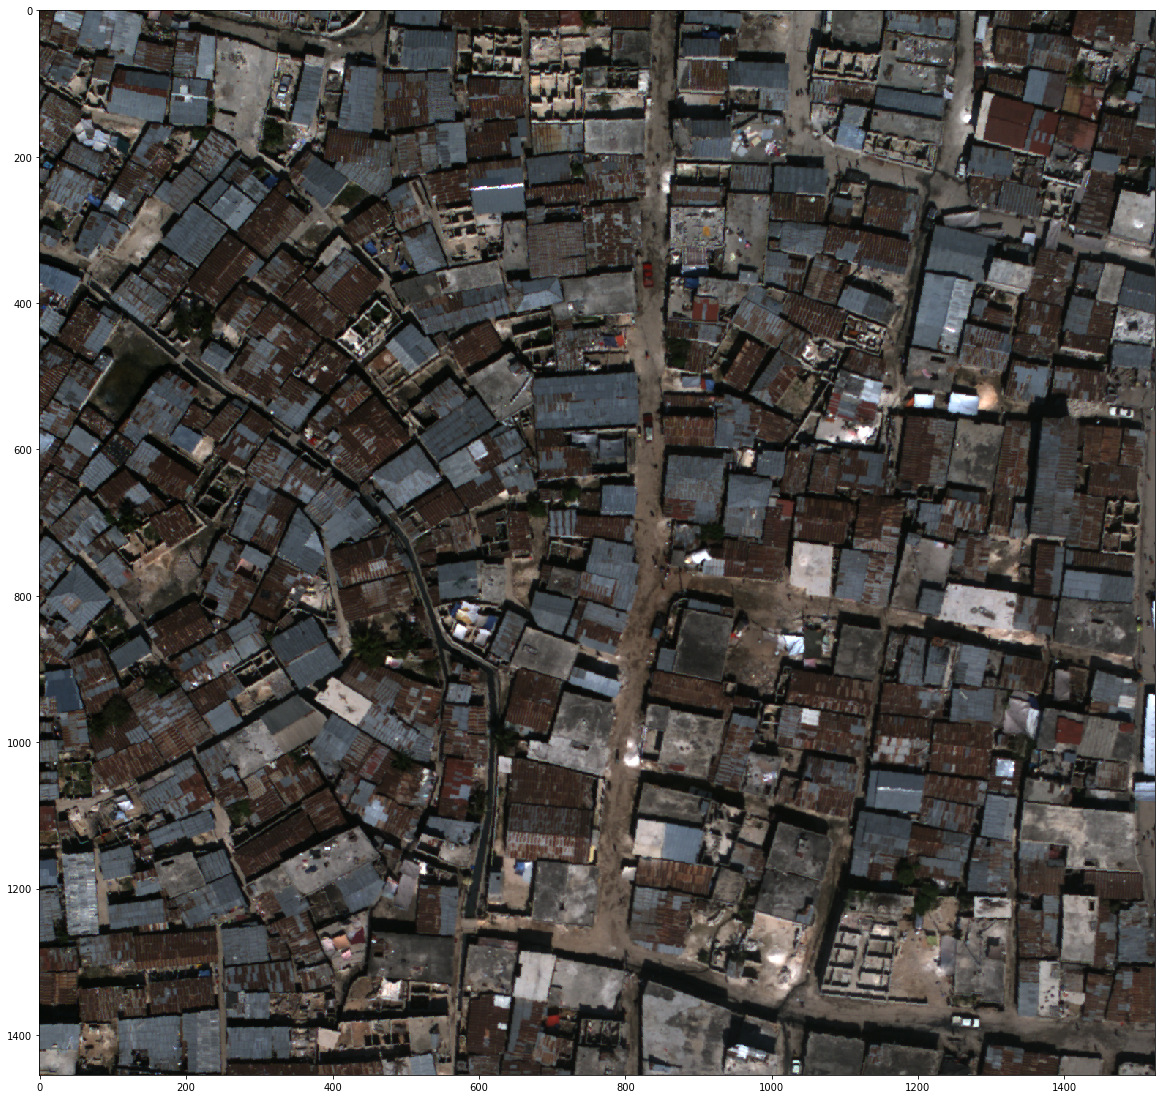

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(img_int8[:,:,:3])

## Segmentación

In [6]:
segments = felzenszwalb(img['img'], scale=80, sigma=1, min_size=1000)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/segmentation/_felzenszwalb.py:60: RuntimeWarning: Got image with third dimension of 6. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


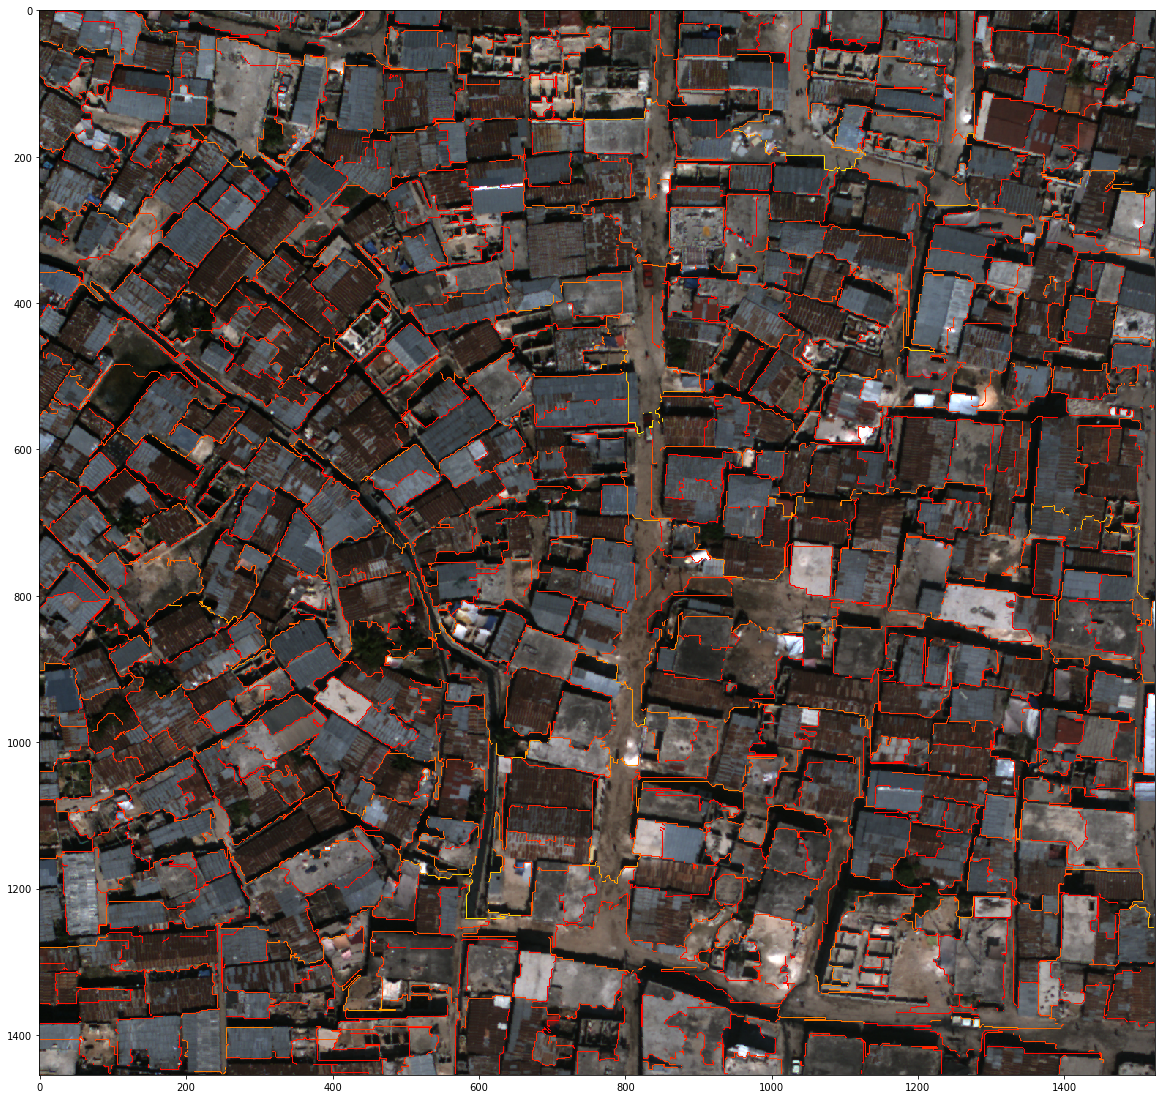

In [7]:
plt.figure(figsize=(20,20))
edges = roberts(segments)
edges[edges == 0] = np.nan

plt.imshow(img_int8[:,:,0:3])
plt.imshow(edges, cmap='autumn')

#### Feature Extraction

In [8]:
nbands = 6
cols = get_features_cols(nbands)

fdf = extract_feature_df(img['img'], segments, cols)

511 segments to process
Segments processed: 0, 0.0 % 
Segments processed: 100, 20.0 % 
Segments processed: 200, 39.0 % 
Segments processed: 300, 59.0 % 
Segments processed: 400, 78.0 % 
Segments processed: 500, 98.0 % 


In [9]:
fdf.head(10)

index  id  area   perimeter  compacity_index  min_1  min_2  min_3  \
0      0   0  5046  401.823376         0.392723  128.0   99.0   94.0   
1      1   1  2394  338.361436         0.262768  160.0  132.0  130.0   
2      2   2  3698  477.130988         0.204128   90.0   83.0   82.0   
3      3   3  3974  370.361436         0.364071  121.0  108.0  101.0   
4      4   4  5849  560.728968         0.233768   94.0   81.0   82.0   
5      5   5  5269  503.243687         0.261446   90.0   83.0   84.0   
6      6   6  5698  614.959415         0.189339   86.0   80.0   77.0   
7      7   7  1241  160.485281         0.605496  126.0  142.0  137.0   
8      8   8  2324  306.461941         0.310952  104.0   94.0   88.0   
9      9   9  4054  388.083261         0.338255   98.0   87.0   84.0   

         min_4  min_5  min_6  max_1  max_2  max_3        max_4  max_5  max_6  \
0  4322.592285    0.0    0.0  585.0  619.0  468.0  5486.581543   4.18   25.0   
1  4280.166504    0.0    2.0  487.0  511.0  429.0  5226.615234   4.19   18.0   
2  4399.460938    0.0    0.0  499.0  440.0  365.0  5207.371582   3.57   25.0   
3  4509.806152    0.0    1.0  474.0  508.0  402.0  5090.804688   3.30   24.0   
4  4421.592285    0.0    0.0  612.0  613.0  474.0  5532.042969   3.19   25.0   
5  4322.634766    0.0    0.0  810.0  775.0  579.0  5248.886719   4.36   25.0   
6  4351.703613    0.0    4.0  507.0  480.0  364.0  5559.491699   4.40   25.0   
7  4567.914062    0.0    3.0  311.0  313.0  272.0  4840.687500   3.38   25.0   
8  4610.831055    0.0    7.0  514.0  503.0  367.0  5379.330078   3.99   24.0   
9  4685.669434    0.0    3.0  536.0  493.0  382.0  5421.134277   5.15   22.0   

       mean_1      mean_2      mean_3       mean_4    mean_5     mean_6  \
0  293.373169  282.673798  243.696793  5031.974121  3.101019  14.284545   
1  339.730591  343.740601  302.953644  4649.177734  3.546387  14.235385   
2  217.647110  199.762573  175.127090  4817.597168  1.343437  14.520378   
3  269.232269  246.107697  200.990692  4792.171387  0.716548  13.662183   
4  229.504013  211.012146  176.451523  4906.168457  0.457938  14.317405   
5  266.897339  246.115585  201.940781  4846.157715  0.135715  14.349430   
6  191.683228  168.226044  142.466125  4743.215332  1.333989  14.381222   
7  242.282028  252.597092  229.736496  4682.837891  2.894706  14.492866   
8  235.493546  205.241821  166.556366  4850.240723  1.560146  14.434132   
9  230.411438  189.349777  152.806122  4962.892090  2.335977  14.263735   

   median_1  median_2  median_3     median_4  median_5  median_6        var_1  \
0     288.0     288.0     249.0  5069.230469      3.50   14.3051  4495.360840   
1     346.0     351.0     308.0  4643.385742      3.72   14.3051  1986.387207   
2     209.0     175.0     153.0  4821.853516      1.52   14.3051  7998.028320   
3     282.0     252.0     202.0  4790.237793      0.00   14.3051  4167.755371   
4     230.0     207.0     170.0  4879.022461      0.00   14.3051  8736.676758   
5     274.0     249.0     200.0  4878.484863      0.00   14.3051  9017.182617   
6     186.0     152.0     130.0  4719.189453      1.65   14.3051  4754.830566   
7     249.0     257.0     236.0  4666.239258      2.96   14.3051   631.954346   
8     214.0     181.0     152.0  4849.127930      1.67   14.3051  7693.774414   
9     209.0     164.0     135.0  4921.917480      2.65   14.3051  6436.496094   

         var_2        var_3         var_4     var_5     var_6  kurtosis_1  \
0  7390.485352  6079.468262  36990.726562  0.897457  1.793794    0.046478   
1  2692.740723  1988.638306  49785.042969  0.735079  1.100074    0.330465   
2  8342.237305  5730.287598  16867.662109  1.424088  6.671508   -0.401401   
3  4255.191895  2579.804199  16030.369141  1.436240  8.121011   -0.282795   
4  8576.999023  4571.434570  34377.339844  0.738974  2.850565    0.974137   
5  8181.606934  4521.875488  34369.042969  0.369865  1.835081    2.530789   
6  4374.479004  2184.812500  21142.794922  1.369071  2.379463    1.79255